In [1]:
from LIMxCMBL.init import *
from scipy.integrate import simpson, trapezoid
import pickle
from tqdm import tqdm, trange

from LIMxCMBL.experiments import *
import matplotlib.pyplot as plt 

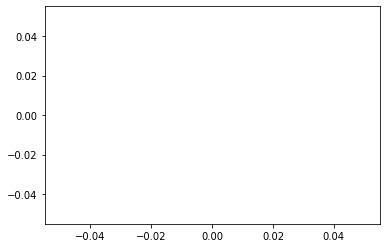

In [2]:
plt.plot()
plt.rcParams.update({
    "text.usetex": True,
    "font.size": "11",
    "font.family" : "serif",
    'figure.constrained_layout.use':True,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'hatch.linewidth':0.1
})

In [3]:
e_colors = {
    'CHIME': '#8932B8',
    'HETDEX': '#3C44AA',
    'COMAP': '#5E7C16',
    'SPHEREx': '#F9801D',
    'CCAT-prime':'#B02E26'
}

In [4]:
e_order = ['CHIME',
          'HETDEX',
          'COMAP',
           'CCAT-prime',
           'SPHEREx',]

In [5]:
_com = r'\textsf{\textbf{Diamonds} mark where $\Lambda = k_\parallel^{\sf fund.}$}'

In [6]:
import matplotlib.patheffects as pe

In [7]:
def hline_text(x, y, text, color="k", fontsize=12, linestyle="-", ax=None,
              left = None, right = None, path_effects = None, ha='right', lw=1,
              pad = .01):
    """ draw hline at y interrupted by text at x """
    if ax is None:
        ax = plt.gca()
    text += ' '
    text = ' ' + text
    label = ax.text(x, y, text, color='k', fontsize=fontsize,
                    va="center", ha=ha,
                   path_effects= path_effects)
    # draw text to get its bounding box
    ax.get_figure().canvas.draw()
    bbox = label.get_window_extent().transformed(ax.transAxes.inverted())
    bbox.x0 -= pad
    bbox.x1 += pad
    bbox = bbox.transformed(ax.transAxes).transformed(ax.transData.inverted())
    # add hlines next to bounding box
    if(left == None):
        left, right = ax.get_xlim()
    ax.hlines([y]*2, [left, bbox.x1], [bbox.x0, right], color=color, linestyle=linestyle, lw=lw)
    
    
    y0, y1 = bbox.y0, bbox.y1
    dy = (y1 - y0)
    yb = (y0 + y1)/2
    ax.plot([left, left], [y-dy/5, y+dy/5], color=color, lw=lw)
    ax.plot([right, right], [y-dy/5, y+dy/5], color=color, lw=lw)

In [8]:
plt_left = plt.rcParams['figure.subplot.left']
plt_right = plt.rcParams['figure.subplot.right']
plt_cntr = (plt_left + plt_right) / 2


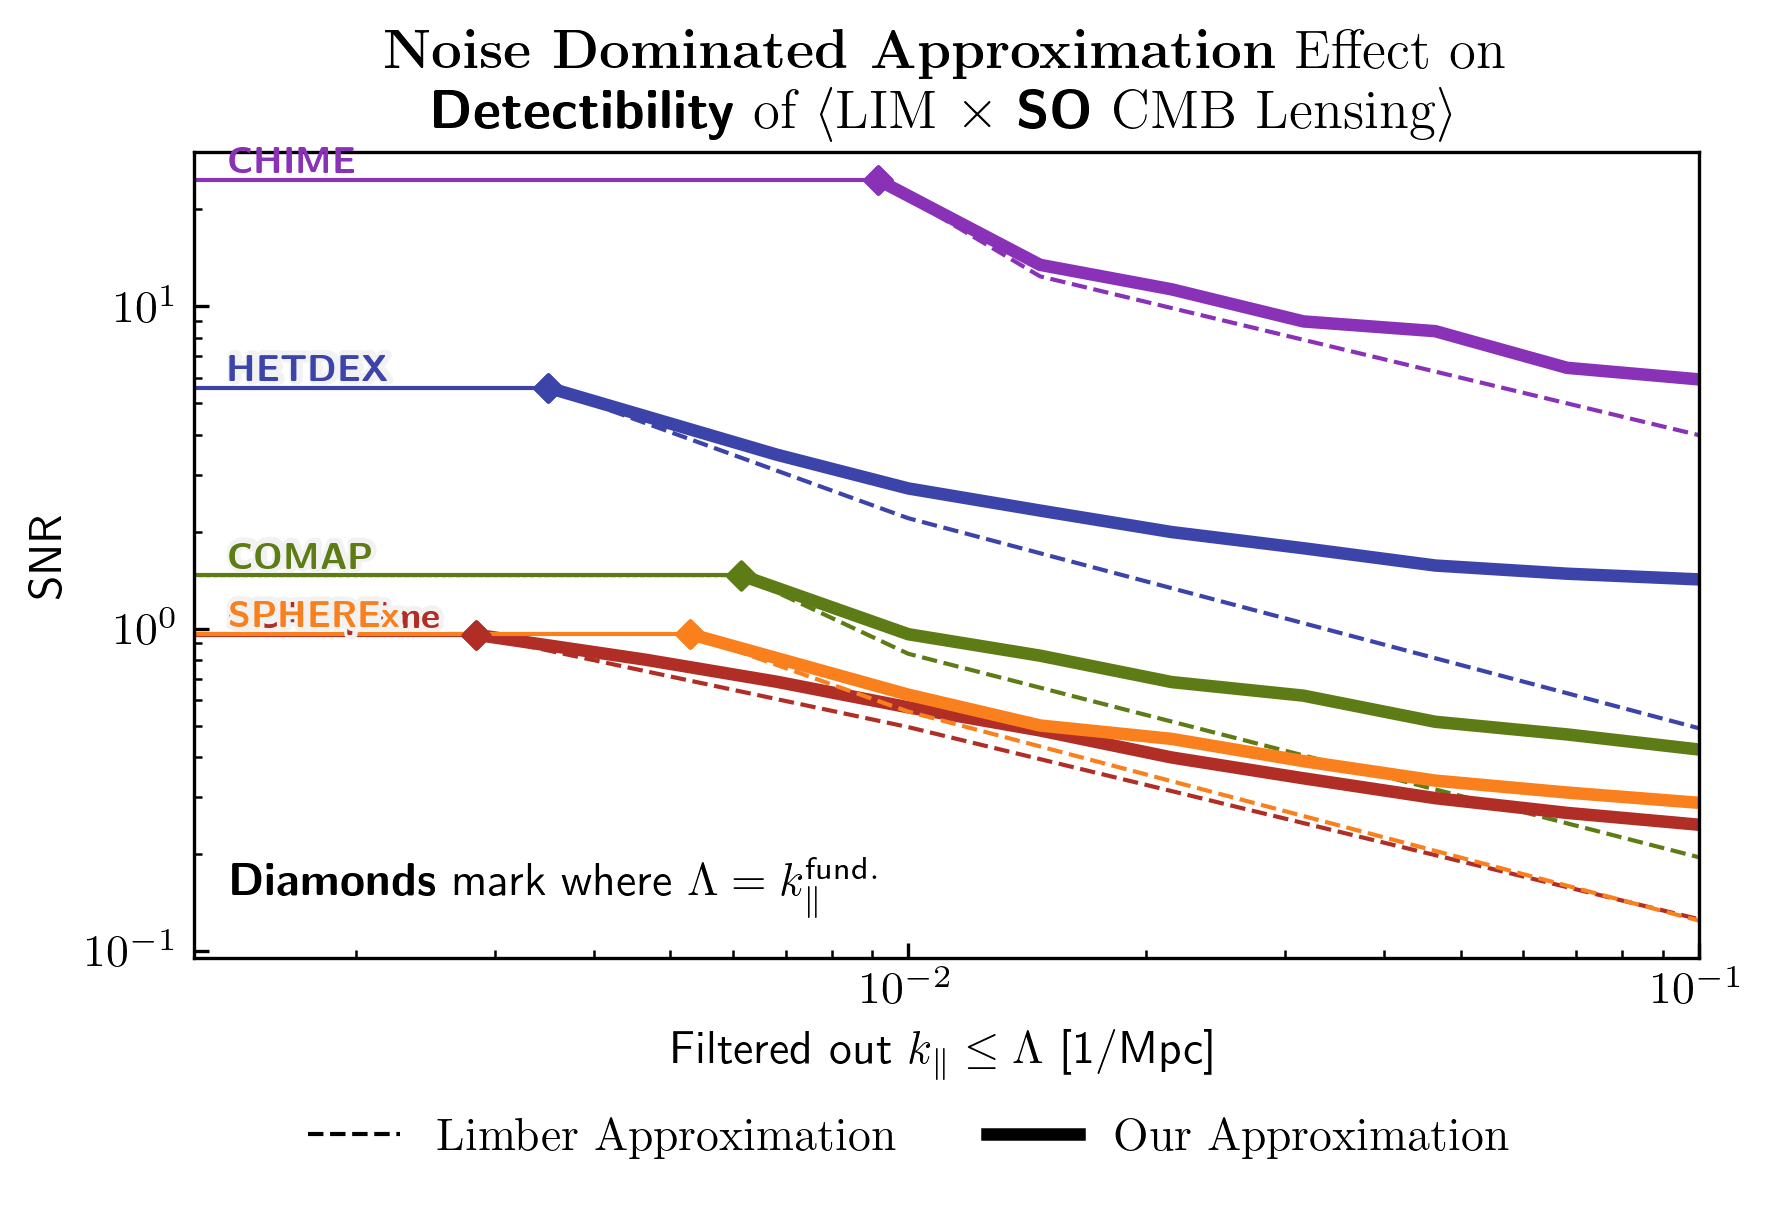

In [24]:
fig = plt.figure(figsize = (5.8, 5.8/1.618), facecolor = 'w', dpi = 300)
xmin = 1.25e-3
sval = '0.95'

# detectibility 
# detect_thresh = 10
# plt.axhspan(0, detect_thresh, color=sval, label='No Detection')
# plt.axhspan(0, detect_thresh, alpha=1, facecolor="None", hatch='/',
#             rasterized=True,
#                                      linewidth=0,
#                                      edgecolor="k")
for experiment in e_order:
    #metadata
    zmin = experiments[experiment]['zmin']
    zmax = experiments[experiment]['zmax']
    line_str = experiments[experiment]['line_str']
    
    Omega_field  =  np.array(experiments[experiment]['Omega_field'].to(u.rad**2)) #rad^2
    chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
    chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))
    
    kpar_fundamental = 2*np.pi/(chimax - chimin)

    ell_fundamental = np.sqrt((2*np.pi)**2 / Omega_field)
    ell_fundamental = max(np.array(ell_fundamental), 10)

    ell_max_survey = np.sqrt((np.pi)**2 / experiments[experiment]['Omega_pix'].to(u.rad**2).value)
    ell_max_survey = np.array(ell_max_survey)

    
    N0_fname = 'so'
    inp_fname = '/scratch/users/delon/LIMxCMBL/LIMBER_SNR_011.007_N0_'+N0_fname+'_'
    limber_SNR2 = -1
    with open(inp_fname+experiment+'_noise_dom.pkl', 'rb') as f:
        limber_SNR2 = pickle.load(f)

        
    inp_fname = '/scratch/users/delon/LIMxCMBL/SNR_011.007_N0_'+N0_fname+'_'
    nonlimber_SNR2 = -1
    with open(inp_fname+experiment+'_noise_dom.pkl', 'rb') as f:
        nonlimber_SNR2 = pickle.load(f)

    #load expeirment
    def get_SNR(SNR2_per_mode_full):
        _Lambdas = np.array(sorted(list(SNR2_per_mode_full.keys())))

        #computing snr
        SNR2_per_Omega_full = np.zeros(len(_Lambdas))
        _idxs = np.where((ells >= ell_fundamental) & (ells <= ell_max_survey))

        for Lambda_idx,Lambda in enumerate(_Lambdas):
            SNR2_per_Omega_full[Lambda_idx] = trapezoid(x = np.log(ells)[_idxs], 
                                                        y = SNR2_per_mode_full[Lambda][_idxs] 
                                                        * ells[_idxs] ** 2 
                                                        / 2 / np.pi)
        SNR = np.sqrt(SNR2_per_Omega_full * Omega_field)
        return _Lambdas, SNR
        
    _Lambdas, SNR_SO_noise_dom = get_SNR(nonlimber_SNR2)
    _Lambdas_limber, SNR_SO_noise_dom_limber = get_SNR(limber_SNR2)


    #plotting snr
    def ploot(_Lambdas, SNR_SO_noise_dom, ls='-', lw=3):
        plt.plot(np.hstack(([kpar_fundamental], _Lambdas[1:])),
                 SNR_SO_noise_dom,
                 c=e_colors[experiment], ls=ls, lw=lw,
                label=r'\textsf{%s}'%experiment)

        _y0 = SNR_SO_noise_dom[0]
        plt.plot([0, kpar_fundamental], 
                 [_y0, _y0],
                 c=e_colors[experiment], ls=ls, lw=lw/3,)


        plt.scatter([kpar_fundamental], [_y0],
                    marker='D',
                    s=20,
                    c=e_colors[experiment],
                    zorder=lw,
                   )
    ploot(_Lambdas, SNR_SO_noise_dom)
    ploot(_Lambdas_limber, SNR_SO_noise_dom_limber, ls='--', lw=1)

    
    #experiment label

        
    _va = 'bottom'
    texty = SNR_SO_noise_dom[0]

        

#     if(experiment=='CCAT-prime' or experiment == 'CHIME'):
#         _va = 'top'
#         texty = SNR_SO[0] * np.exp(-0.1)

    if(texty < detect_thresh):
        plt.text(x = xmin * np.exp(0.1), y= texty, 
                 s=r'\textsf{\textbf{%s}}'%experiment,
                 horizontalalignment='left',
                 fontsize=9,
                 color='none',
                 path_effects=[pe.withStroke(linewidth=2, foreground=sval)],
                 verticalalignment=_va)

    plt.text(x = xmin * np.exp(0.1), y= texty, 
             s=r'\textsf{\textbf{%s}}'%experiment,
             horizontalalignment='left',
             fontsize=9,
             color=e_colors[experiment],
             verticalalignment=_va)

    
# axes
plt.yscale('log')
plt.xscale('log')
plt.xlim(xmin, 1e-1)
plt.ylim(None, 30)
plt.ylabel(r'\textsf{SNR}')
plt.xlabel(r'\textsf{Filtered out} $k_\parallel \leq \Lambda$ \sf[1/Mpc]')
plt.title(r'\textbf{Noise Dominated Approximation} Effect on' +'\n'+r'\textbf{\textsf{Detectibility}} of $\langle$LIM $\times$ \textsf{\textbf{SO}} CMB Lensing$\rangle$')



plt.text(0.025,0.05, _com,
        verticalalignment='bottom',
        horizontalalignment='left',
         fontsize=11,
        transform=plt.gca().transAxes)

# hline_text(x=xmin*np.exp(0.1), y=detect_thresh, text=r'\textsf{\textbf{Detectibility Threshold}}', lw=1,
#            color='k', fontsize=11, linestyle='-',
#            ha = 'left', pad=0.009)


from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = [
    Line2D([0], [0], color='k', lw=1, ls='--', label='Limber Approximation'),
    Line2D([0], [0], color='k', lw=3, label=r'Our Approximation'),
]

fig.legend(handles=legend_elements, 
           loc='lower center',
           bbox_to_anchor=(plt_cntr, -0.1),
           frameon=False,
           ncol=2)